In [1]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image
import random

/opt/conda/envs/DiNAT/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_root = 'siim'
img_dir = 'images'
ann_dir = 'labels'
# classes = ('sick', 'non_sick')
# palette = [[255, 0, 0], [0, 0, 0]]
classes = ('non_sick', 'sick')
palette = [[0,0,0], [128, 0, 0]]
# palette = [[0,0,0], [1, 1, 1]]
# palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
#            [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [3]:
split_dir = 'splits'

In [4]:
# divide train and val
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

random.Random(0).shuffle(filename_list)

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # chose first 4/5 as train
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # chose last 1/5 as val
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [5]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SIIM_pneumothorax(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

# Searching

In [6]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
cfg = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [7]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth'
    ),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropou

In [8]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 2000

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'work_dirs/tutorial/iter_1000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 1500
cfg.log_config.interval = 100
cfg.evaluation.interval = 1500
cfg.checkpoint_config.interval = 1500

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2

In [9]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [10]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-17 02:31:38,105 - mmseg - INFO - Loaded 8540 images
2022-11-17 02:31:38,850 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth
2022-11-17 02:31:39,285 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

2022-11-17 02:31:44,959 - mmseg - INFO - Loaded 2135 images
2022-11-17 02:31:44,960 - mmseg - INFO - Start running, host: cheng666999@dl-dev, work_dir: /home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial
2022-11-17 02:31:44,961 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) 

KeyboardInterrupt: 

In [93]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
result = inference_segmentor(model, img)

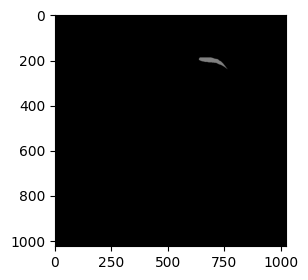

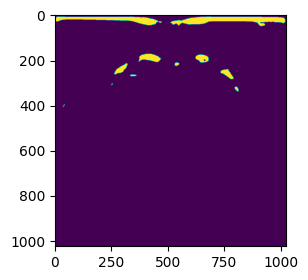

In [94]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)

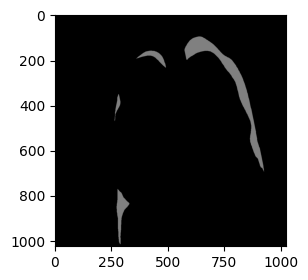

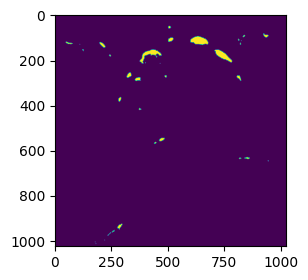

/opt/conda/envs/DiNAT/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 300x300 with 0 Axes>

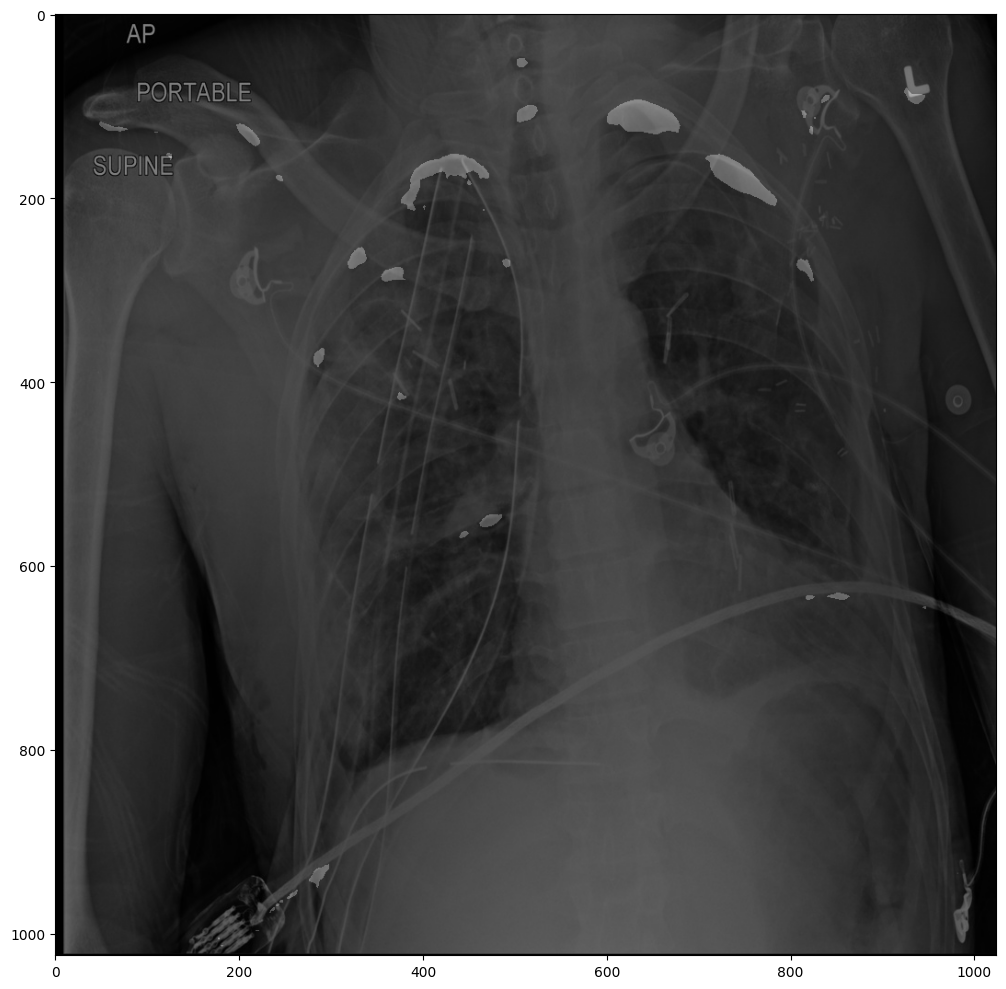

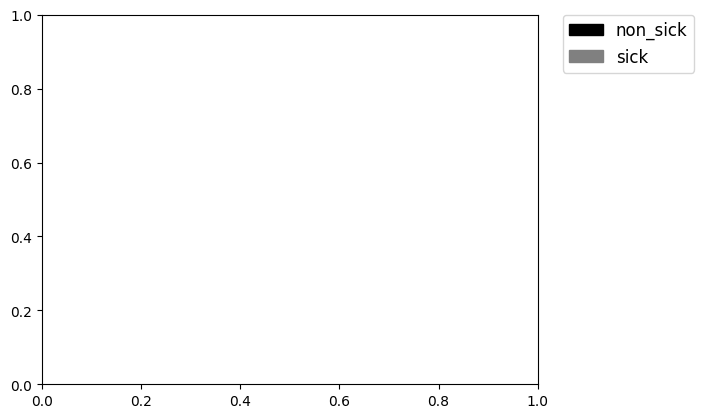

In [95]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

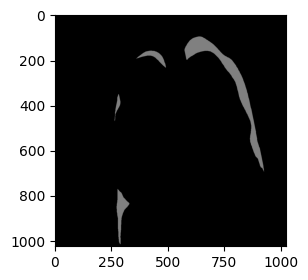

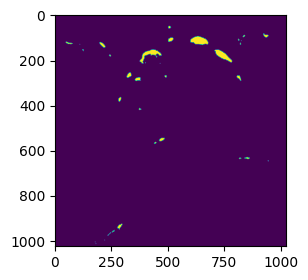

In [96]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])

# Hyperparam set 1

Base DiNAT
pretrain = imagenet
DiceLoss with class weights[0.3, 0.7]
Batch_size = 8
train_set = 8540
val_set = 2135

iters / epoch = 1057

Always warmup = 11000
Train iters = 10580

In [82]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
cfg = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [83]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
# cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.9], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.decode_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=3.0, ignore_index=255, loss_name='loss_dice'),
    dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, loss_name='loss_focal')
]
# cfg.model.decode_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]

cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
# cfg.model.auxiliary_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 3500

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.resume_from = 'work_dirs/tutorial/iter_3000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 3000
cfg.log_config.interval = 200
cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 3000

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2

In [84]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [85]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-18 04:12:04,986 - mmseg - INFO - Loaded 3743 images
2022-11-18 04:12:05,816 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth
2022-11-18 04:12:06,053 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

2022-11-18 04:12:06,781 - mmseg - INFO - Loaded 936 images
2022-11-18 04:12:06,782 - mmseg - INFO - load checkpoint from local path: work_dirs/tutorial/iter_3000.pth
2022-11-18 04:12:08,032 - mmseg - INFO - resumed from epoch: 1, iter 2999
2022-11-18 04:12:08,038 - mmseg - INFO - Start running, host: cheng666999@dl-dev, work_dir: /home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial
2022-11-18 04:12:08,041 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 936/936, 13.8 task/s, elapsed: 68s, ETA:     0s

2022-11-18 04:13:56,227 - mmseg - INFO - per class results:
2022-11-18 04:13:56,229 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| non_sick |  99.3 | 99.58 |
|   sick   | 37.54 | 60.44 |
+----------+-------+-------+
2022-11-18 04:13:56,230 - mmseg - INFO - Summary:
2022-11-18 04:13:56,230 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.31 | 68.42 | 80.01 |
+-------+-------+-------+
2022-11-18 04:13:56,242 - mmseg - INFO - Iter(val) [936]	aAcc: 0.9931, mIoU: 0.6842, mAcc: 0.8001, IoU.non_sick: 0.9930, IoU.sick: 0.3754, Acc.non_sick: 0.9958, Acc.sick: 0.6044


In [86]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
result = inference_segmentor(model, img)

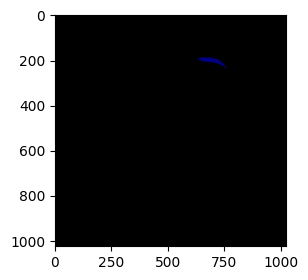

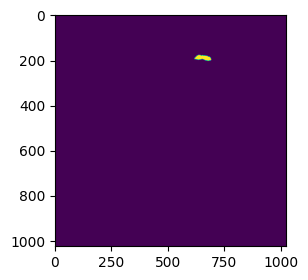

In [87]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)

<Figure size 300x300 with 0 Axes>

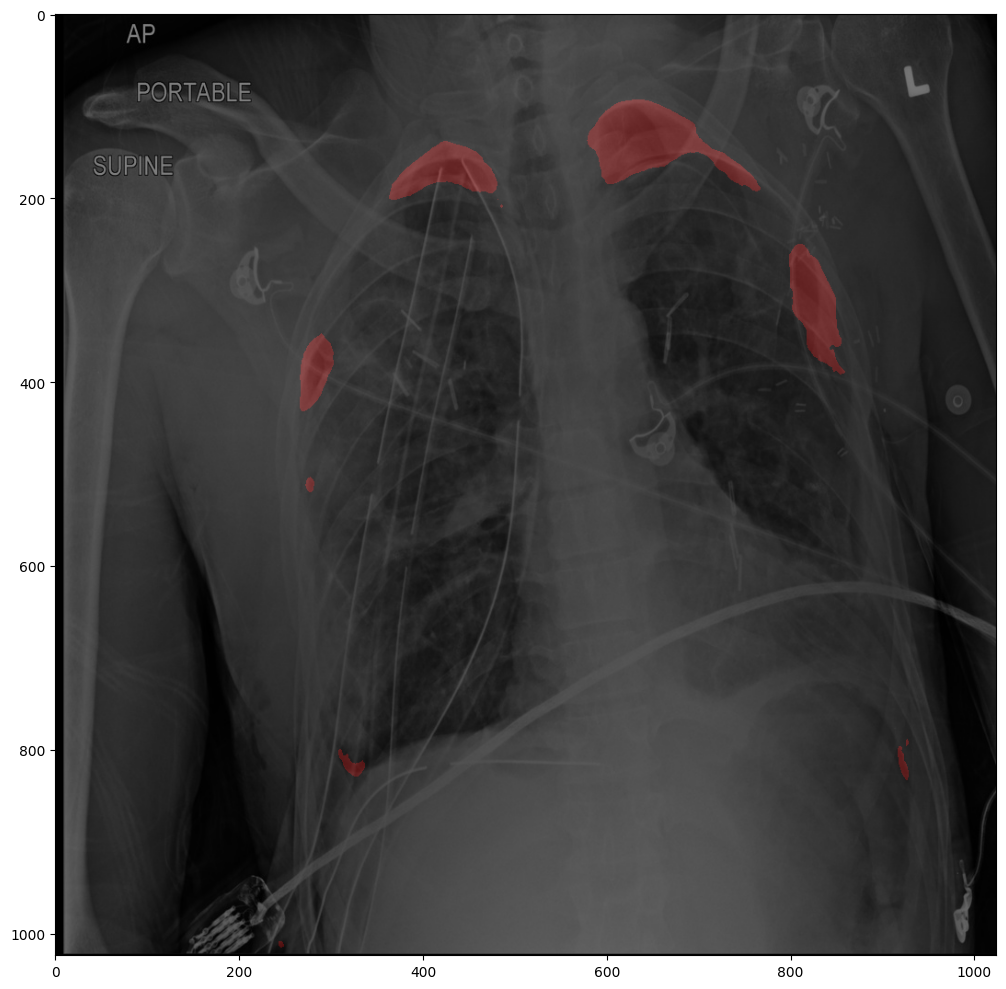

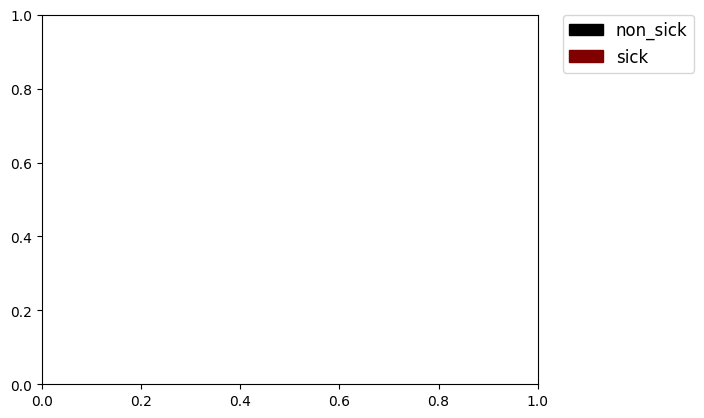

In [88]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

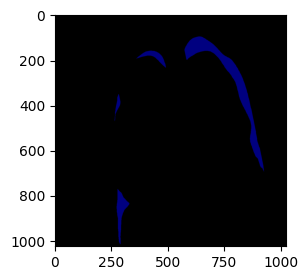

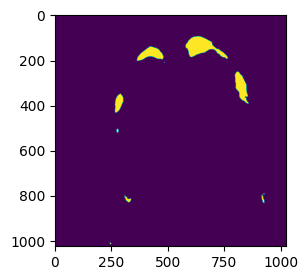

In [89]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])

In [16]:
import glob
img_list = glob.glob('siim/images/*')

In [17]:
def convert(x:str):
    x = x.replace('images', 'labels')
    return x

/tmp/ipykernel_25831/3160788643.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3,3))


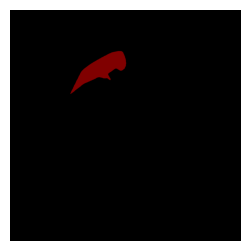

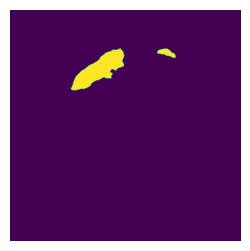

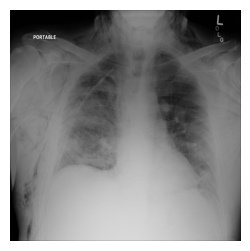

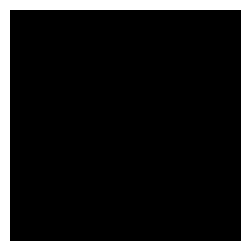

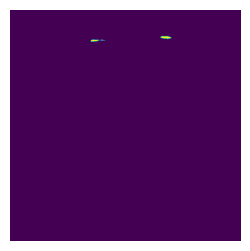

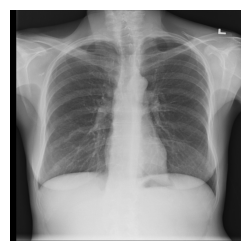

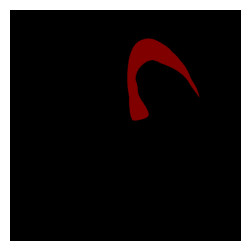

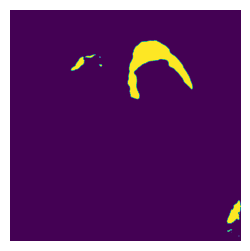

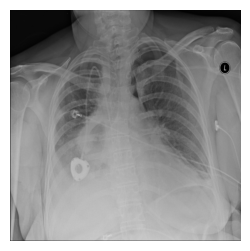

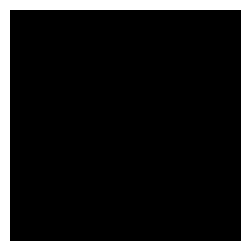

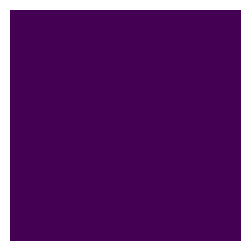

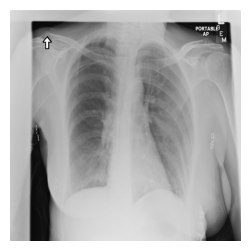

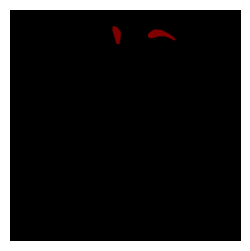

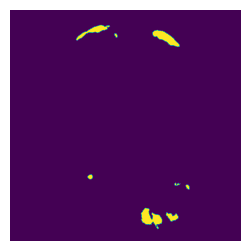

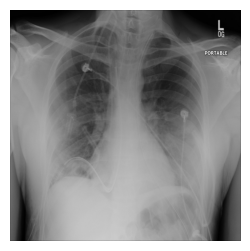

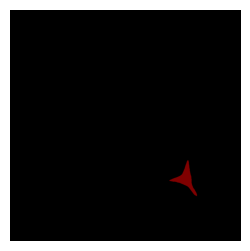

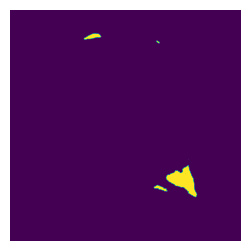

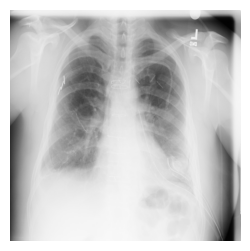

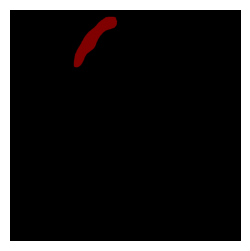

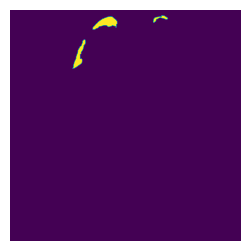

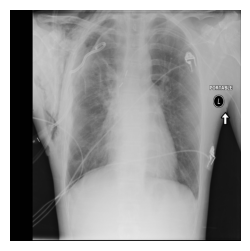

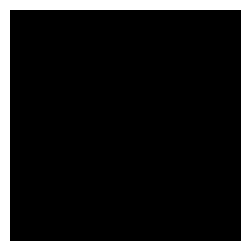

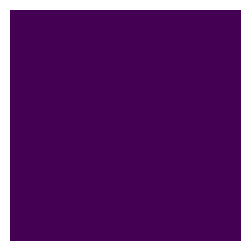

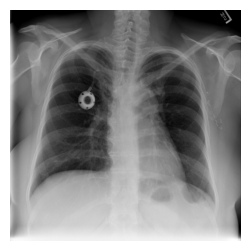

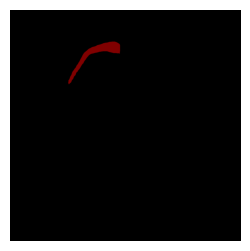

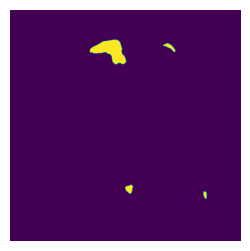

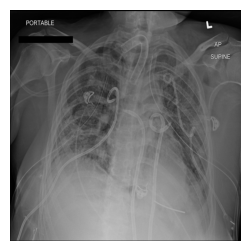

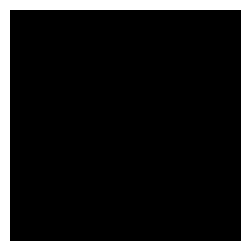

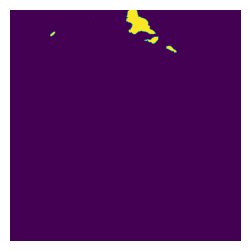

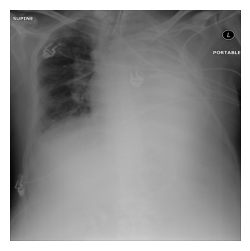

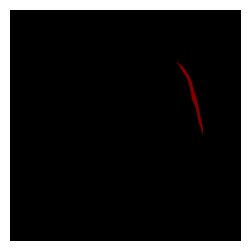

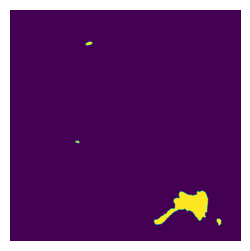

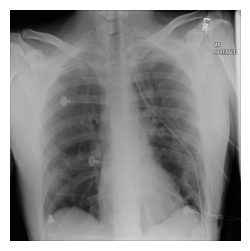

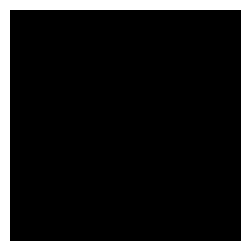

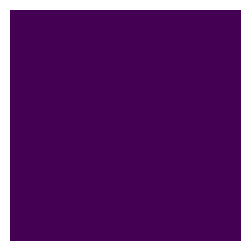

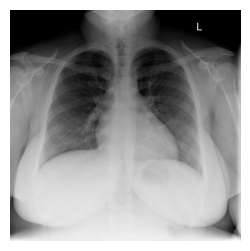

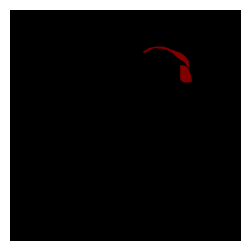

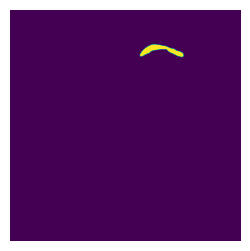

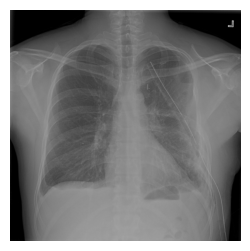

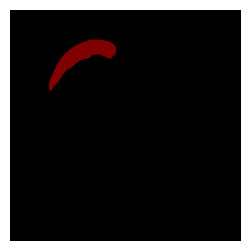

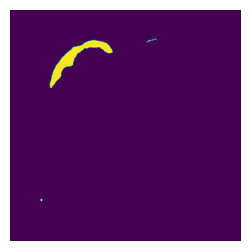

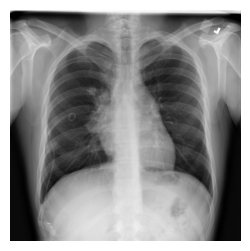

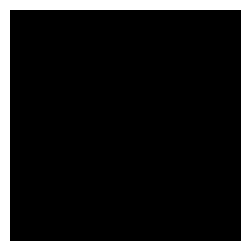

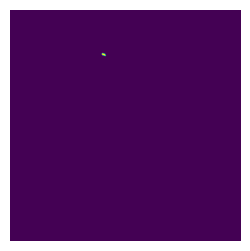

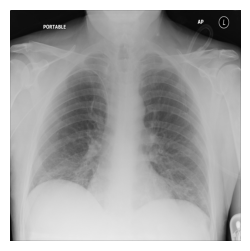

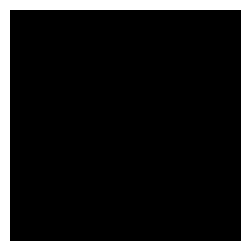

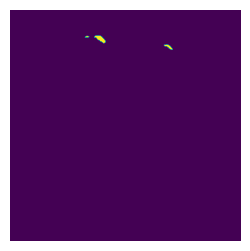

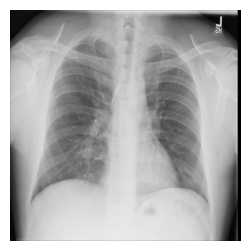

In [20]:
#15 - 20
count = 0
for i in range(5, len(img_list)):
    img = mmcv.imread(img_list[i])
    # img = plt.imread(path)

    model.cfg = cfg
    result = inference_segmentor(model, img)
    label_img = plt.imread(convert(img_list[i]))
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(label_img)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(result[0])
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(img)
    if i == 20:
        break


# Hyperparam set 2

Base DiNAT
pretrain = imagenet
DiceLoss with class weights[0.3, 1.0]
Batch_size = 8
train_set = 8540
val_set = 2135

iters / epoch = 1057

Always warmup = 11000
Train iters = 10580

In [61]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
cfg2 = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [62]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
# cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.9], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.decode_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=3.0, ignore_index=255, loss_name='loss_dice'),
    dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, loss_name='loss_focal')
]

# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
cfg.model.auxiliary_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.4, ignore_index=255, loss_name='loss_dice'),
    dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.1, loss_name='loss_focal')
]
# cfg.model.auxiliary_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 2000

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'work_dirs/tutorial/iter_1000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 1500
cfg.log_config.interval = 200
cfg.evaluation.interval = 1500
cfg.checkpoint_config.interval = 1500

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2

In [63]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [64]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-17 03:38:31,373 - mmseg - INFO - Loaded 8540 images
2022-11-17 03:38:32,083 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth
2022-11-17 03:38:32,333 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

2022-11-17 03:38:33,127 - mmseg - INFO - Loaded 2135 images
2022-11-17 03:38:33,129 - mmseg - INFO - Start running, host: cheng666999@dl-dev, work_dir: /home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial
2022-11-17 03:38:33,130 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2135/2135, 15.9 task/s, elapsed: 134s, ETA:     0s

2022-11-17 03:47:58,149 - mmseg - INFO - per class results:
2022-11-17 03:47:58,152 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
| non_sick | 99.26 | 99.44 |
|   sick   | 17.33 | 46.71 |
+----------+-------+-------+
2022-11-17 03:47:58,152 - mmseg - INFO - Summary:
2022-11-17 03:47:58,153 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.26 | 58.3 | 73.08 |
+-------+------+-------+
2022-11-17 03:47:58,158 - mmseg - INFO - Iter(val) [2135]	aAcc: 0.9926, mIoU: 0.5830, mAcc: 0.7308, IoU.non_sick: 0.9926, IoU.sick: 0.1733, Acc.non_sick: 0.9944, Acc.sick: 0.4671


In [65]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
result = inference_segmentor(model, img)

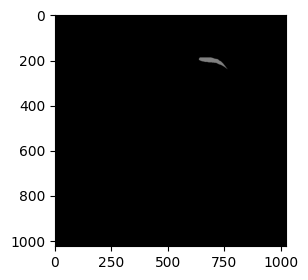

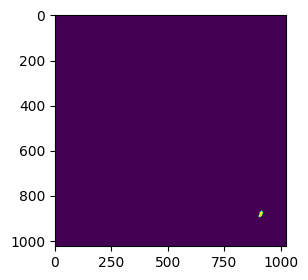

In [66]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)

/opt/conda/envs/DiNAT/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 300x300 with 0 Axes>

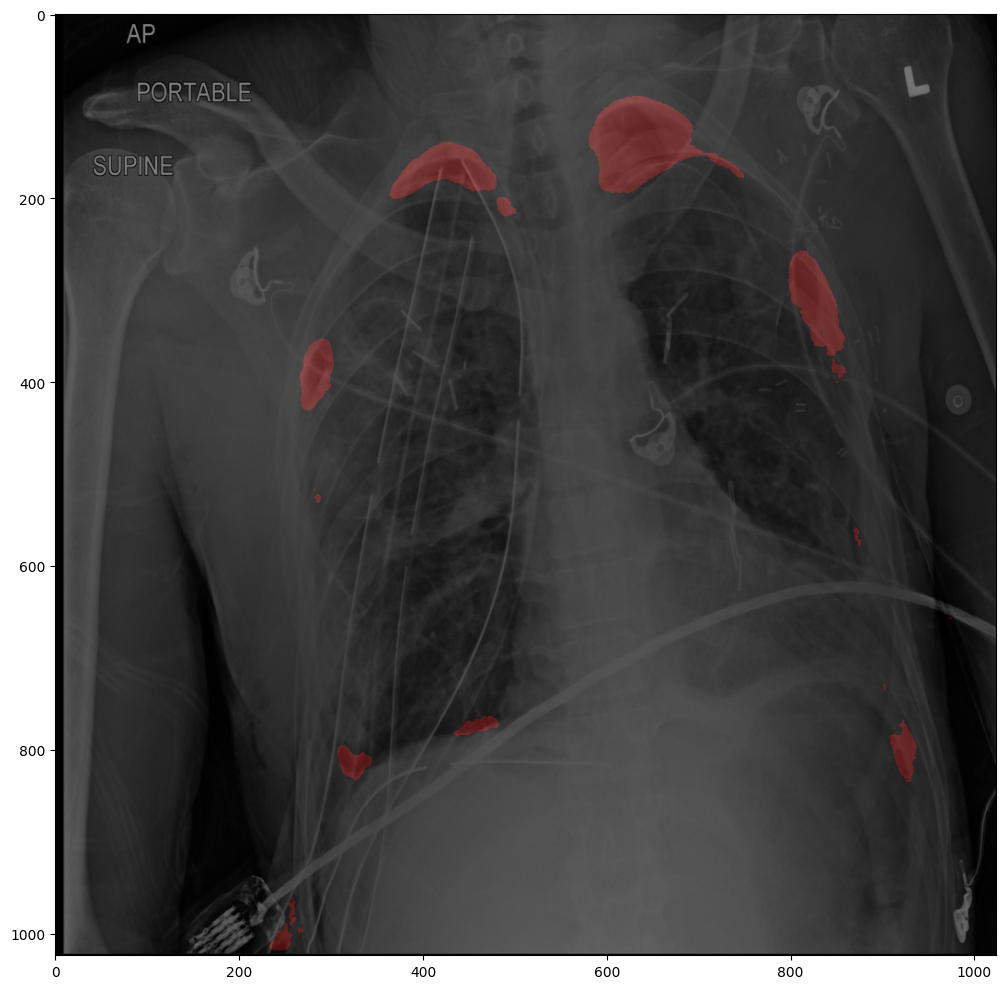

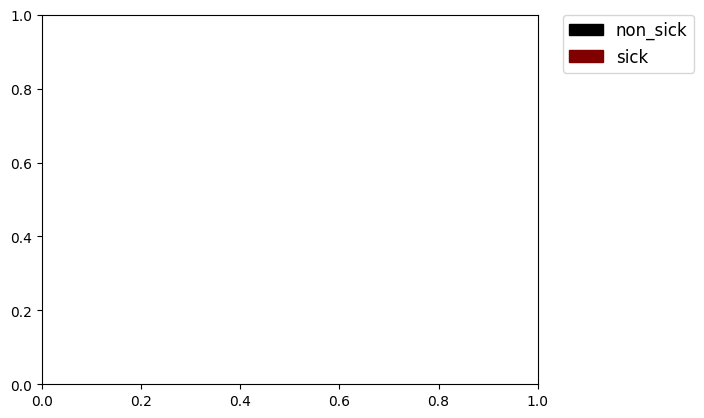

In [18]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

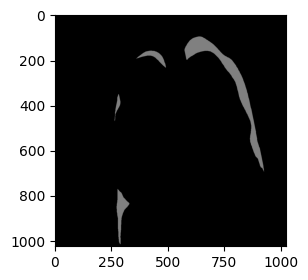

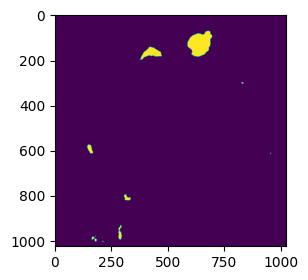

In [68]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])

# Hyperparam set 3

Base DiNAT
pretrain = imagenet
DiceLoss with class weights[0.3, 0.8]
FocalLoss gamma = 2.0, alpha = 1.0, class weights[0.3, 0.8]
Batch_size = 8
train_set = 8540
val_set = 2135

iters / epoch = 1057

Always warmup = 11000
Train iters = 10580

In [30]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
cfg = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [31]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
# cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.9], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.decode_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=3.0, ignore_index=255, loss_name='loss_dice'),
    # dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, loss_name='loss_focal')
    dict(type='CrossEntropyLoss', use_sigmoid=False, use_mask=False, reduction='mean', class_weight=[0.3, 0.7], loss_weight=2.0, loss_name='loss_ce')
]
# cfg.model.decode_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]

# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
cfg.model.auxiliary_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
    dict(type='CrossEntropyLoss', use_sigmoid=False, use_mask=False, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, loss_name='loss_ce')
    # dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.5, loss_name='loss_focal')
]
# cfg.model.auxiliary_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 2500

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'work_dirs/tutorial/iter_1000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 2000
cfg.log_config.interval = 200
cfg.evaluation.interval = 2000
cfg.checkpoint_config.interval = 2000

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2

In [32]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [33]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-12 20:31:52,904 - mmseg - INFO - Loaded 4303 images
2022-11-12 20:31:54,061 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth
2022-11-12 20:31:54,438 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

2022-11-12 20:31:55,206 - mmseg - INFO - Loaded 1076 images
2022-11-12 20:31:55,208 - mmseg - INFO - Start running, host: cheng666999@dl-dev, work_dir: /home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial
2022-11-12 20:31:55,209 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1076/1076, 16.1 task/s, elapsed: 67s, ETA:     0s

2022-11-12 20:41:56,974 - mmseg - INFO - per class results:
2022-11-12 20:41:56,977 - mmseg - INFO - 
+----------+-------+------+
|  Class   |  IoU  | Acc  |
+----------+-------+------+
| non_sick | 99.09 | 99.3 |
|   sick   | 29.47 | 64.2 |
+----------+-------+------+
2022-11-12 20:41:56,978 - mmseg - INFO - Summary:
2022-11-12 20:41:56,979 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.09 | 64.28 | 81.75 |
+-------+-------+-------+
2022-11-12 20:41:56,983 - mmseg - INFO - Iter(val) [1076]	aAcc: 0.9909, mIoU: 0.6428, mAcc: 0.8175, IoU.non_sick: 0.9909, IoU.sick: 0.2947, Acc.non_sick: 0.9930, Acc.sick: 0.6420


In [34]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
result = inference_segmentor(model, img)

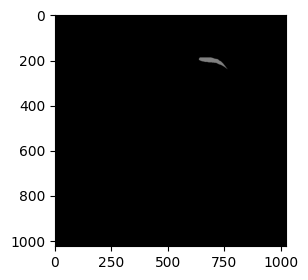

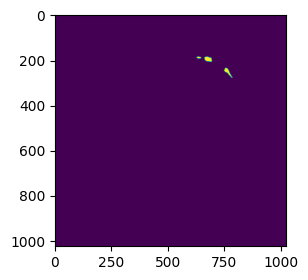

In [35]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)

/opt/conda/envs/DiNAT/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 300x300 with 0 Axes>

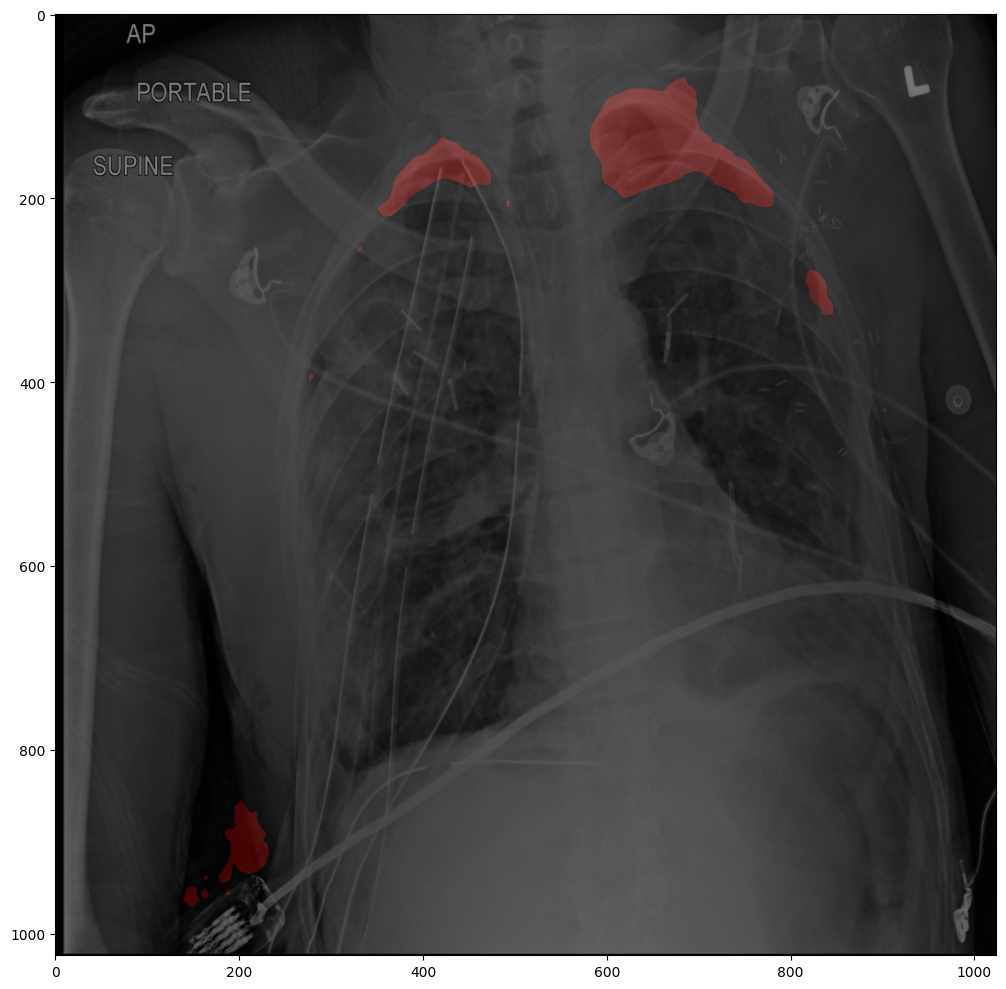

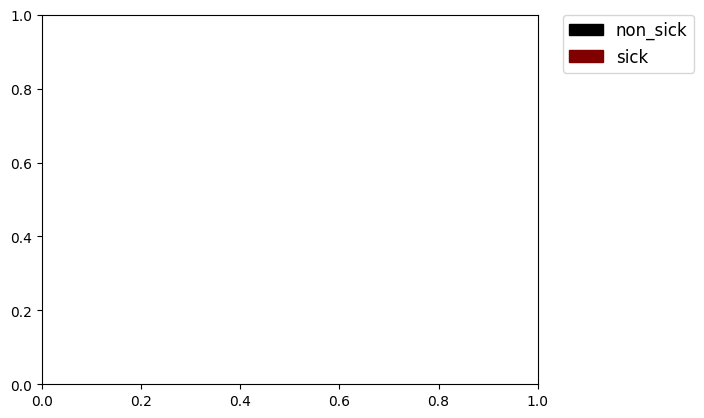

In [36]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

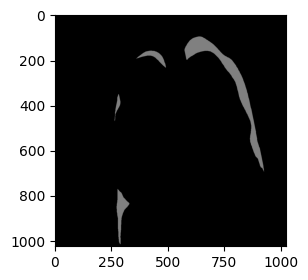

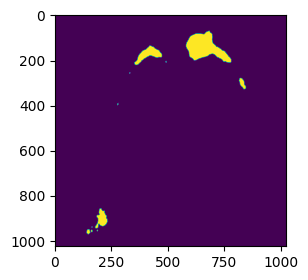

In [37]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])

# Hyperparam set 4

Large DiNAT
pretrain = imagenet
DiceLoss with class weights[0.3, 1.0]
Batch_size = 8
train_set = 8540
val_set = 2135

iters / epoch = 1057

Always warmup = 25000
Train iters = 20000

In [29]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [30]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.8], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.8], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 25000

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# cfg.load_from = 'work_dirs/tutorial/iter_1000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 20000
cfg.log_config.interval = 2000
cfg.evaluation.interval = 10000
cfg.checkpoint_config.interval = 10000

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=192,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[6, 12, 24, 48],
        drop_path_rate=0.3,
        kernel_size=7,
        dilations=[[1, 20, 1], [1, 5, 1, 10],
                   [1, 2, 1, 3, 1, 4, 1, 5, 1, 2, 1, 3, 1, 4, 1, 5, 1, 5],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet22k/dinat_large_in22k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[192, 384, 768, 1536],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        chann

In [31]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [32]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-12 11:39:45,135 - mmseg - INFO - Loaded 8540 images
2022-11-12 11:39:47,002 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet22k/dinat_large_in22k_224.pth
2022-11-12 11:39:47,434 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

2022-11-12 11:39:48,470 - mmseg - INFO - Loaded 2135 images
2022-11-12 11:39:48,472 - mmseg - INFO - Start running, host: cheng666999@dl-dev, work_dir: /home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial
2022-11-12 11:39:48,478 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW        

OSError: [Errno 28] No space left on device

In [ ]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
result = inference_segmentor(model, img)

In [ ]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)

In [ ]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])

# Use checkpoint to load model

In [49]:
from mmcv import Config
# cfg = Config.fromfile('configs/dinat/upernet_dinat_small_512x512_160k_ade20k.py')
cfg = Config.fromfile('configs/dinat/upernet_dinat_base_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_tiny_512x512_160k_ade20k.py')
# cfg = Config.fromfile('configs/dinat/upernet_dinat_large_640x640_160k_ade20k.py')

In [50]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth'
    ),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropou

In [56]:
from mmseg.apis import set_random_seed

# modify decode and auxiliary head loss function
# .DiceLoss(smooth=1, exponent=2, reduction='mean', class_weight=None, loss_weight=1.0, ignore_index=255, loss_name='loss_dice', **kwargs)
# cfg.model.decode_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.9], loss_weight=1.0, ignore_index=255, loss_name='loss_dice')
cfg.model.decode_head.loss_decode = [
    dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=3.0, ignore_index=255, loss_name='loss_dice'),
    dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.8, reduction='mean', class_weight=[0.3, 0.7], loss_weight=1.0, loss_name='loss_focal')
]
# cfg.model.decode_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]

cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 0.7], loss_weight=0.4, ignore_index=255, loss_name='loss_dice')
# cfg.model.auxiliary_head.loss_decode = [
#     dict(type='DiceLoss', smooth=1, exponent=2, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, ignore_index=255, loss_name='loss_dice'),
#     dict(type='CrossEntropyLoss', use_sigmoid=True, use_mask=False, reduction='mean', class_weight=[0.3, 1.0], loss_weight=1.0, loss_name='loss_ce')
# ]
# cfg.model.auxiliary_head.loss_decode = dict(type='DiceLoss', loss_weight=0.4, ignore_idex=255, loss_name='loss_dice')

# .CrossEntropyLoss(use_sigmoid=False, use_mask=False, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_ce', avg_non_ignore=False)
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

# garbage trash
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss',use_sigmoid=True, gamma=2.0, alpha=0.6, reduction='mean', class_weight=None, loss_weight=1.0, loss_name='loss_focal')

# warm up iters
cfg.lr_config.warmup_iters = 2500

# using pretrain or not
# cfg.model.backbone.pretrained='https://shi-labs.com/projects/dinat/checkpoints/ade20k/upernet_dinat_base.pth'

# apply drop_out(drop_rate)
# cfg.model.backbone.drop_rate = 0.3


cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'SIIM_pneumothorax'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.load_from = '/home/cheng666999/Desktop/Neighborhood-Attention-Transformer/segmentation/work_dirs/tutorial/iter_2000.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 2000
cfg.log_config.interval = 200
cfg.evaluation.interval = 2000
cfg.checkpoint_config.interval = 2000

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='DiNAT',
        embed_dim=128,
        mlp_ratio=2.0,
        depths=[3, 4, 18, 5],
        num_heads=[4, 8, 16, 32],
        drop_path_rate=0.5,
        kernel_size=7,
        dilations=[[1, 16, 1], [1, 4, 1, 8],
                   [1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4, 1, 2, 1, 3, 1, 4],
                   [1, 2, 1, 2, 1]],
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        in_patch_size=4,
        frozen_stages=-1,
        layer_scale=1e-05,
        pretrained=
        'https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth',
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2

In [57]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot
import matplotlib.patches as mpatches
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from nat import *
from dinat import *
from dinats import *

In [58]:

datasets = [build_dataset(cfg.data.train)]

model = build_segmentor(cfg.model)

# model.CLASSES = datasets[0].CLASSES

#mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
#train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-11-17 03:35:36,047 - mmseg - INFO - Loaded 8540 images
2022-11-17 03:35:36,711 - mmseg - INFO - load checkpoint from http path: https://shi-labs.com/projects/dinat/checkpoints/imagenet1k/dinat_base_in1k_224.pth
2022-11-17 03:35:36,945 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias



In [59]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')

model.cfg = cfg
model.eval()
result = inference_segmentor(model, img)

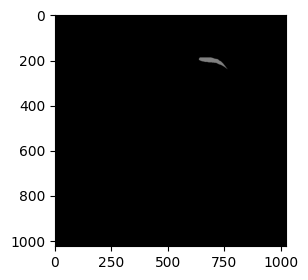

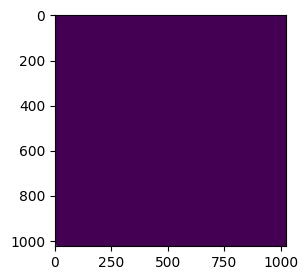

In [60]:
t = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.305.1517875162.307235.png')
plt.figure(figsize=(3,3))
plt.imshow(t)
plt.figure(figsize=(3,3))
plt.imshow(result[0])
# display(t.shape)


/opt/conda/envs/DiNAT/lib/python3.8/site-packages/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 300x300 with 0 Axes>

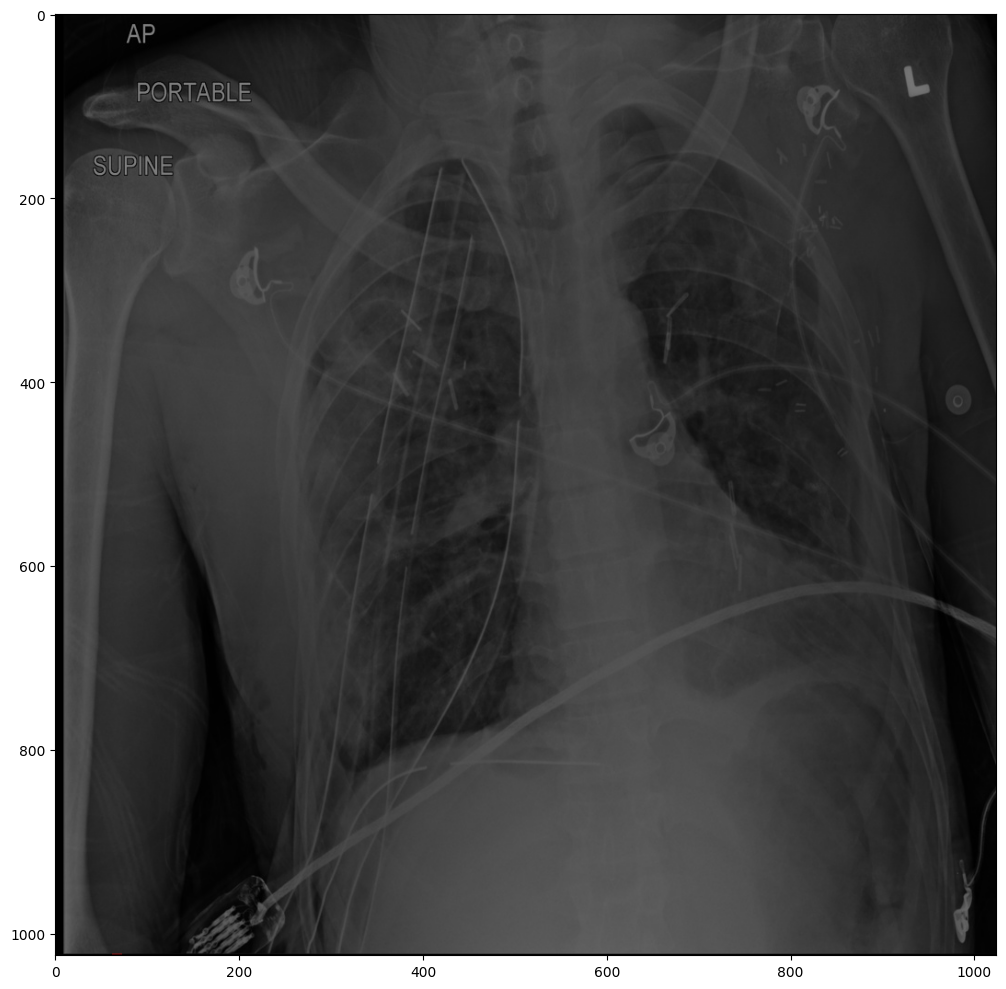

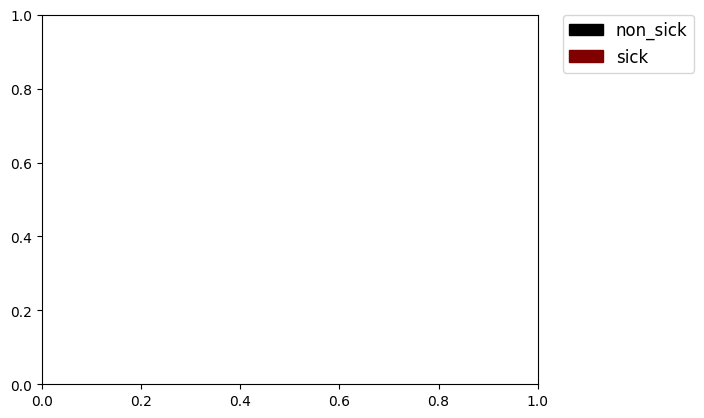

In [47]:
img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(3, 3))
show_result_pyplot(model, img, result, palette)

patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

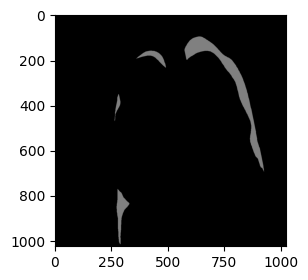

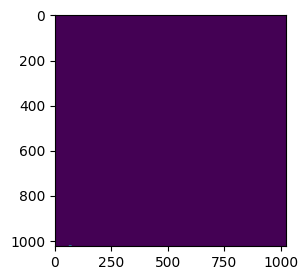

In [48]:
test_img = mmcv.imread('siim/images/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')
test_label = mmcv.imread('siim/labels/1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147.png')

plt.figure(figsize=(3,3))
plt.imshow(test_label)
plt.figure(figsize=(3,3))
plt.imshow(result[0])